#  Project 1 - Bee Subspecie Classification (logistic regression vs neural network approach) 

### Import relevant libraries

In [1]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import plotly.express as px
#to load matlab mat files
from scipy.io import loadmat

size = 50

## PART 2: Load data

In [14]:
ds = pd.read_csv('bee_dataset/ml_data.csv')
features=ds['features']
y1=ds['class']
y2 = {'Italian honey bee':1,'Carniolan honey bee':2,
      'Russian honey bee':3,'1 Mixed local stock 2':4,'Western honey bee':5}
y = (pd.Series(y1)).map(y2)
y = np.array(y)
y = np.reshape(y, (-1, 1))
#print(type(y))
#print(y)
n_examples = features.shape[0]
feature_size = size*size
X = np.empty((n_examples,feature_size), float)
for idx,f in enumerate(features):
        arr_f = np.fromstring(f, dtype=float, sep=' ')
        arr_f = np.reshape(arr_f, (1,arr_f.shape[0]))
        X[idx,:] = np.copy(arr_f)
#X = np.copy(arr)
print(y.shape)
print(X.shape)

(508, 1)
(508, 2500)


508


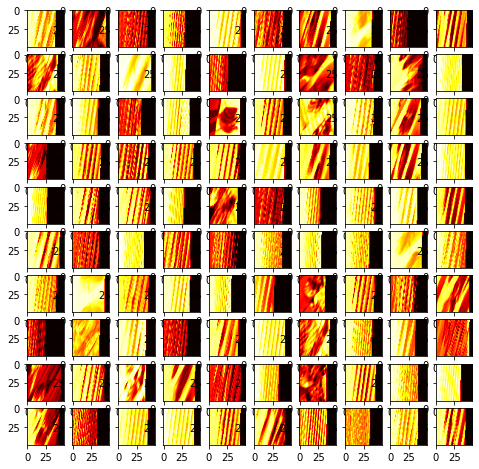

In [3]:
print(n_examples)
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
                                                        #reshape back to 20x20 pixel image
        axis[i,j].imshow(X[np.random.randint(0,n_examples),:].reshape(size,size,order="F"), cmap="hot")

In [15]:
# Add sigmoid FUNCTION from the previous lab
def sigmoid(z):
    """
    return the sigmoid of z
    """
    gz= 1/(1+np.exp(-z))

    return gz

In [16]:
# Add costFunctionReg FUNCTION from the previous lab (the function that computes the regularized cost and the gradients)
def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    #number of training examples 
    m = len(y)
        
    #vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X,theta))
    
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    
    #cost function without regularization term
    cost = sum(error)/m
    
    #add regularization term to the cost function L2 norm
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    #gradient of theta_0
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

In [17]:
# Add gradientDescent FUNCTION from the previous lab (the function that returns the optimal theta vector and J_history)
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        #call CostFunctionReg 
        cost, grad = costFunctionReg(X,y,theta,Lambda)
        
        #update theta
        descent = alpha * grad
        theta = theta - descent #theta - (alpha*grad)
        
        J_history.append(cost)
    
    return theta , J_history

In [18]:
def oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, K):
    """
    Inputs:
    numpy array of data X and labels y
    initial_theta - inicialized vector of model parameters theta 
    alpha - learning rate
    num_iters - number of iterations
    Lambda - regularization parameter 
    K -number of classes
    
    ONEVSALL trains K Logistic Regression classifiers using gradient descent. 
    
    Returns:   
    all_theta - Kxn matrix where i-th row corresponds to the i-th classifier, n parameters
    all_J - the evolution of cost function during each iteration (J_history) for all K classifiers
    
    """
    all_theta = []
    all_J=[]
    
    #number of training examples
    m=X.shape[0]
    
    #number of features
    n=X.shape[1]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m,1)),X,axis=1)
    
    for i in range(1,K+1):
        y = np.where(y==i,1,0)
        theta , J_history = gradientDescent(X,y,initial_theta,alpha,num_iters,Lambda)
        
        # sdd the vector of optimized parameters theta of classifier i
        all_theta.extend(theta)
                
        # add the cost function history of classifier i
        all_J.extend(J_history)
        
    return np.array(all_theta).reshape(K,n+1), all_J

In [22]:
#Inicialize vector theta =0
initial_theta = np.zeros((X.shape[1] + 1, 1))

#Optimization hyper-parameters 
alpha=1 #learning rate
num_iters=300
Lambda=0.1

all_theta, all_J = oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, 5)

C:\Users\biaco\AppData\Local\Temp/ipykernel_11520/1828240669.py:14: RuntimeWarning: divide by zero encountered in log
  error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
C:\Users\biaco\AppData\Local\Temp/ipykernel_11520/1828240669.py:14: RuntimeWarning: invalid value encountered in multiply
  error = (-y * np.log(h)) - ((1-y)*np.log(1-h))


In [ ]:
plt.plot(all_J)  #All classifiers
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [ ]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of image X(i) for each class and predict the label
    
    return a vector of prediction
    """
    #number of training examples
    m = X.shape[0]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m,1)),X,axis=1)
    
    predictions = np.dot (X, all_theta.T) # predictions.shape =(5000,10)  X(5000x401) * all_theta(401x10) = 5000x10
    #np.argmax returns indices of the max element of the array in a particular axis.
    #+1 in order to label 0 as 10. 
    return np.argmax(predictions,axis=1)+1

In [ ]:
pred = predictOneVsAll(all_theta, X)

#Check that pred.shape  = (5000,) => rank 1 array. You need to reshape it !!!
pred = pred.reshape((pred.shape[0], 1))
m = X.shape[0]
print("Training Set Accuracy:",sum(pred==y)[0]/m*100,"%")

# PART 3: Neural Network training

In [23]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg

In [24]:
#Computes the gradient of sigmoid function
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

In [25]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [26]:
input_layer_size  = 2500
hidden_layer_size = 25
num_labels = 5

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [27]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [ ]:
alpha=1 #learning rate
num_iters=2000
Lambda=0.1
num_labels = 5

nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)

Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

In [ ]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
        #number of training examples
    m = X.shape[0]
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m,1)),X,axis=1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1=np.dot(X, Theta1.T)  #Inputs to the hidden layer neurons
    a1=sigmoid(z1)  #Outputs  of the hidden layer neurons
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)),a1, axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2=np.dot(a1, Theta2.T) #Inputs to the output layer neurons
    a2=sigmoid(z2)  #Outputs  of the output layer neurons
    
    return np.argmax(a2,axis=1)+1

In [ ]:
pred3 = predict(Theta1, Theta2, X)

m = X.shape[0]
print("Training Set Accuracy:",sum(pred3[:,np.newaxis]==y)[0]/m*100,"%")

In [ ]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(nnJ_history)  #
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")